# COMP0189: Applied Artificial Intelligence
## Week 7 (Model Interpretation and Feature selection)


## Learning goals 🎯
1. Learn how to use different strategies for interpreting machine learning models.
2. Learn how to properly implement feature selection to avoid leaking information.

### Acknowledgements
- https://scikit-learn.org/stable/
- https://scikit-learn.org/stable/auto_examples/inspection/plot_linear_model_coefficient_interpretation.html#id1

In [1]:
%pip install scikit-learn==1.7.2 matplotlib==3.10.8 pandas==2.3.3 seaborn==0.13.2 imbalanced-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 2.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 24.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.7/8.7 MB 20.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.4/12.4 MB 17.0 MB/s eta 0:00:00
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
  Attempting uninstall: matplotlib
    Found existing installation: matplotlib 3.10.0
    Uninstalling matplotlib-3.10.0:
      Successfully uninstalled matplotlib-3.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. T

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.cluster import hierarchy

# Part 1: A common error: leaking information

We will start with a toy example to illustrate a common mistake when using feature selection. We will create a random dataset with 10.000 features and 100 samples.

In [2]:
rnd = np.random.RandomState(seed=0)
X = rnd.normal(size=(100, 10000))
y = rnd.normal(size=(100,))

In [3]:
print(X.shape)

(100, 10000)


We might consider that 10.000 is a very high number of features and that we need to use feature selection. So, let's select the 5% most informative features.

In [4]:
from sklearn.feature_selection import SelectPercentile, f_regression

select = SelectPercentile(score_func=f_regression,
                          percentile=5)
select.fit(X, y)
X_sel = select.transform(X)

print(X_sel.shape)

(100, 500)


Now we will create a pipeline to pre-process the data and fit a regression model to see if we can predict the random labels from the selected features.

In [6]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import Ridge

X_train, X_test, y_train, y_test = train_test_split(X_sel, y, random_state=0)
pipe = make_pipeline(StandardScaler(), Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

0.9202615356385515

These are great results but how did we get such good results on a random dataset?

These results are due to information leaking as the features were selected before spliting the data into train and test splits.

### Task 1: Implement a correct pipeline to pre-process the data, select the top 5% features and train a regression model to predict th random labels.

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0)
pipe = make_pipeline(StandardScaler(), SelectPercentile(score_func=f_regression, percentile=5), Ridge())
pipe.fit(X_train, y_train)
pipe.score(X_test, y_test)

-0.1906190193095303

These results make more sense from what we would expect with random labels.

# Part 2: Model interpretation and feature selection

### QSAR Biodegradation Dataset

**Source:** [UCI Machine Learning Repository](https://archive.ics.uci.edu/dataset/254/qsar+biodegradation)

**Samples:** 1,055 chemicals (356 ready biodegradable, 699 not ready biodegradable)

**Target Variable:** Experimental class (**RB** = ready biodegradable, **NRB** = not ready biodegradable)

**Features:** 41 molecular descriptors (e.g., SpMax_L, nHM, F04[C-N], nO, nN) used to classify biodegradability.

**Purpose:** Development of Quantitative Structure-Activity Relationship (QSAR) models to predict the biodegradability of chemical compounds.

In [13]:
import pandas as pd

# Load dataset
df = pd.read_csv("biodegradation.csv")


# Display the first few rows
df.head()

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX,experimental class
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,2.949,1.591,0,7.253,0,0,RB
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,3.315,1.967,0,7.257,0,0,RB
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,1,3.076,2.417,0,7.601,0,0,RB
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,1,3.046,5.000,0,6.690,0,0,RB
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,3.351,2.405,0,8.003,0,0,RB


Now we identify features X and targets y. The column "experimental class" is our target variable (i.e., the variable which we want to predict).

In [14]:
df.replace(["RB","NRB"],[1,0], inplace = True) #apply decoding
#rename target for better readability
df.rename(columns = {"experimental class": "degradable"}, inplace = True);

# Define features (X) and target (y)
X = df.drop(columns=["degradable"])  # Exclude non-feature columns
y = df["degradable"]  # Target variable (1 = ready biodegradable, 0 = not ready biodegradable)

# Display summary statistics
X.describe(include="all")

/tmp/ipython-input-1161956074.py:1: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.replace(["RB","NRB"],[1,0], inplace = True) #apply decoding


,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX
count,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,...,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000,1055.000000
mean,4.782644,3.069508,0.716588,0.042654,0.980095,0.290047,1.646445,37.055640,1.376303,1.803791,...,0.129858,0.883412,1.274882,0.961137,3.918240,2.558417,0.686256,8.629492,0.051185,0.723223
std,0.546916,0.831308,1.462452,0.256010,2.332955,1.073771,2.224822,9.144466,1.963521,1.775435,...,0.644057,1.520467,2.273994,1.257013,0.999602,0.642765,1.090389,1.241986,0.318970,2.239286
min,2.000000,0.803900,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,2.267000,1.467000,0.000000,4.917000,0.000000,0.000000
25%,4.481000,2.502750,0.000000,0.000000,0.000000,0.000000,0.000000,30.450000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,3.487500,2.103000,0.000000,7.991000,0.000000,0.000000
50%,4.828000,3.046300,0.000000,0.000000,0.000000,0.000000,1.000000,37.500000,1.000000,2.000000,...,0.000000,0.000000,0.000000,1.000000,3.726000,2.458000,0.000000,8.499000,0.000000,0.000000
75%,5.125000,3.437650,1.000000,0.000000,1.000000,0.000000,3.000000,43.400000,2.000000,3.000000,...,0.000000,1.000000,2.000000,2.000000,3.987000,2.870500,1.000000,9.020500,0.000000,0.000000
max,6.496000,9.177500,12.000000,3.000000,36.000000,13.000000,18.000000,60.700000,24.000000,12.000000,...,8.000000,12.000000,18.000000,7.000000,10.695000,5.825000,8.000000,14.700000,4.000000,27.000000


In [15]:
X.head()

,SpMax_L,J_Dz(e),nHM,F01[N-N],F04[C-N],NssssC,nCb-,C%,nCp,nO,...,nCrt,C-026,F02[C-N],nHDon,SpMax_B(m),Psi_i_A,nN,SM6_B(m),nArCOOR,nX
0,3.919,2.6909,0,0,0,0,0,31.4,2,0,...,0,0,0,0,2.949,1.591,0,7.253,0,0
1,4.170,2.1144,0,0,0,0,0,30.8,1,1,...,0,0,0,0,3.315,1.967,0,7.257,0,0
2,3.932,3.2512,0,0,0,0,0,26.7,2,4,...,0,0,0,1,3.076,2.417,0,7.601,0,0
3,3.000,2.7098,0,0,0,0,0,20.0,0,2,...,0,0,0,1,3.046,5.000,0,6.690,0,0
4,4.236,3.3944,0,0,0,0,0,29.4,2,4,...,0,0,0,0,3.351,2.405,0,8.003,0,0


Our target for prediction: degradable.


In [16]:
# Display the first few values
df["degradable"]

,degradable
0,1
1,1
2,1
3,1
4,1
...,...
1050,0
1051,0
1052,0
1053,0


Handle imbalanced data

In [17]:
from imblearn.under_sampling import RandomUnderSampler

In [18]:
print("Before Undersampling, counts of label '1': {}".format(sum(y == 1)))
print("Before Undersampling, counts of label '0': {} \n".format(sum(y == 0)))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)

print('After Undersampling, the shape of train_X: {}'.format(X_res.shape))
print('After Undersampling, the shape of train_y: {} \n'.format(y_res.shape))

print("After Undersampling, counts of label '1': {}".format(sum(y_res == 1)))
print("After Undersampling, counts of label '0': {}".format(sum(y_res == 0)))

Before Undersampling, counts of label '1': 356
Before Undersampling, counts of label '0': 699 

After Undersampling, the shape of train_X: (712, 41)
After Undersampling, the shape of train_y: (712,) 

After Undersampling, counts of label '1': 356
After Undersampling, counts of label '0': 356


## Exploratory data analysis

We now split the sample into a train and a test dataset. Only the train dataset will be used in the following exploratory analysis. This is a way to emulate a real situation where predictions are performed on an unknown target, and we don’t want our analysis and decisions to be biased by our knowledge of the test data.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, random_state=42,stratify=y_res)

First, let’s get some insights by looking at the a matrix showing the correlation of all features with each other between them. Only numerical variables will be used.

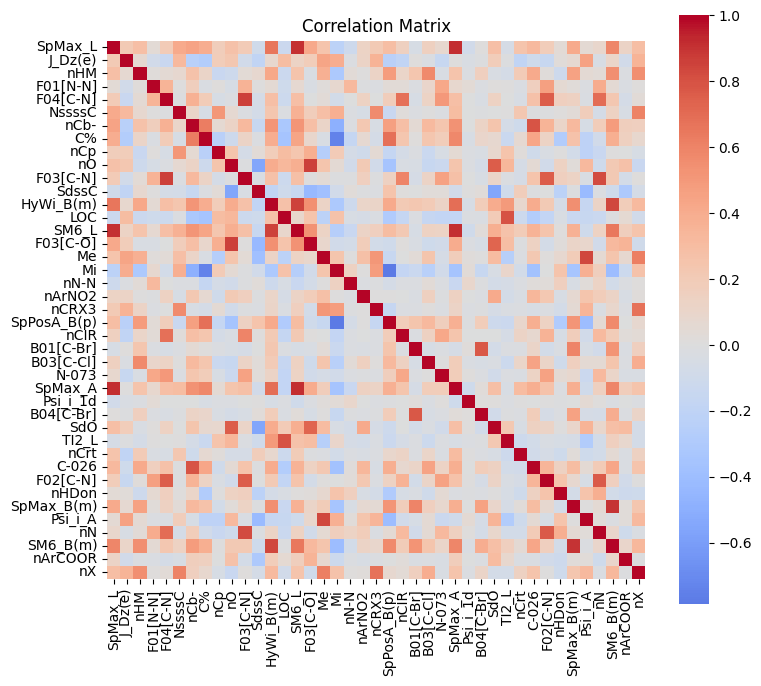

In [20]:
correlation_matrix = X_train.corr()

plt.figure(figsize=(8, 7))
sns.heatmap(correlation_matrix, cmap='coolwarm', center=0, square=True,
xticklabels=correlation_matrix.columns, yticklabels=correlation_matrix.columns)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Matrix')
plt.tight_layout()
plt.show()

It is often easier to see structure in the correlation matrix if we reorder the features using hierarchical clustering.

/tmp/ipython-input-3101108421.py:8: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage = hierarchy.linkage(distance_matrix, method='average')


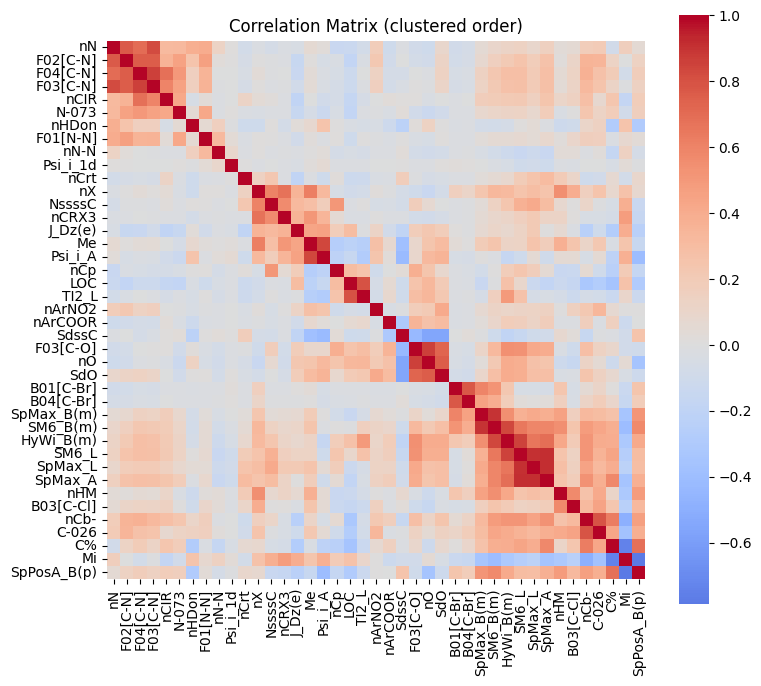

In [21]:
# Compute the correlation matrix
correlation_matrix = X_train.corr()

# Compute distance matrix using absolute correlation (to consider both positive/negative)
distance_matrix = 1 - np.abs(correlation_matrix)

# Perform hierarchical clustering
linkage = hierarchy.linkage(distance_matrix, method='average')
order = hierarchy.dendrogram(linkage, no_plot=True)['leaves']
reordered_corr = correlation_matrix.iloc[order, order]

# Plot clustered heatmap
plt.figure(figsize=(8, 7))
sns.heatmap(reordered_corr, cmap='coolwarm', center=0, square=True,
xticklabels=reordered_corr.columns, yticklabels=reordered_corr.columns)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Matrix (clustered order)')
plt.tight_layout()
plt.show()

Before designing a machine learning pipeline, we should check the type of data that we are dealing with:

In [22]:
# Check dataset information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1055 entries, 0 to 1054
Data columns (total 42 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   SpMax_L      1055 non-null   float64
 1   J_Dz(e)      1055 non-null   float64
 2   nHM          1055 non-null   int64  
 3   F01[N-N]     1055 non-null   int64  
 4   F04[C-N]     1055 non-null   int64  
 5   NssssC       1055 non-null   int64  
 6   nCb-         1055 non-null   int64  
 7   C%           1055 non-null   float64
 8   nCp          1055 non-null   int64  
 9   nO           1055 non-null   int64  
 10  F03[C-N]     1055 non-null   int64  
 11  SdssC        1055 non-null   float64
 12  HyWi_B(m)    1055 non-null   float64
 13  LOC          1055 non-null   float64
 14  SM6_L        1055 non-null   float64
 15  F03[C-O]     1055 non-null   int64  
 16  Me           1055 non-null   float64
 17  Mi           1055 non-null   float64
 18  nN-N         1055 non-null   int64  
 19  nArNO2

All features are numerical and unbounded, suggesting we should scale all of them before training.

## Task 2: Machine Learning Pipeline


### Task 2.1 Implement a **machine learning pipeline** that includes **preprocessing and cross-validation** to optimize the model's hyperparameters.
- Use the pipeline with **linear SVM** and **regularized logistic regression with L1 and elastic-net regularization** to predict whether a chemical is **degradable or non-degradable** based on the given features.
- Create a table to show the performance of the different models.
- Plot the confusion matrix and ROC curve for each model.

In [23]:
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Preprocessing: Standardize numerical features
preprocessor = make_column_transformer(
    (StandardScaler(), X_train.columns),
    remainder="passthrough"
)

In [25]:
from sklearn.base import BaseEstimator
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

def optimise_hyperparameters(model: BaseEstimator, param_grid: dict):
    preprocess_and_train = Pipeline([
        ('preprocessor', preprocessor),
        ('classify', model)
    ])

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    grid_search = GridSearchCV(
        estimator=preprocess_and_train,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        error_score=0,
        verbose=1,
        refit=True
    )

    # Fit GridSearchCV
    return grid_search.fit(X_train, y_train)

# defining parameter range
cv_svc = optimise_hyperparameters(
    LinearSVC(dual="auto", random_state=42),
    {'classify__C': [0.1, 1]}
)
model_svc=cv_svc.best_estimator_

cv_lasso = optimise_hyperparameters(
    LogisticRegression(
        penalty="l1",  # Lasso (L1 regularization)
        solver="liblinear",  # Required for L1 penalty
        max_iter=100000,
    ),
    {'classify__C': np.logspace(-3, 3, 10)}
)
model_Lasso = cv_lasso.best_estimator_

cv_en = optimise_hyperparameters(
    LogisticRegression(
        penalty="elasticnet",
        solver="saga",
        max_iter=100000,
    ),
    {'classify__C': np.logspace(-3, 3, 10), "classify__l1_ratio": [0.1, 0.5, 0.9]}
)
model_EN = cv_en.best_estimator_

print("Done training models")

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Fitting 5 folds for each of 30 candidates, totalling 150 fits
Done training models


In [26]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, balanced_accuracy_score
from sklearn.pipeline import Pipeline

def get_metrics(name: str, model: Pipeline, use_proba: bool = False):
    # Predictions
    y_pred_test = model.predict(X_test)

    # Probabilities for AUC computation
    y_proba_test = model.predict_proba(X_test)[:, 1] if use_proba else model.decision_function(X_test)

    # Compute classification metrics
    metrics_test = {
        "Model": name,
        "Accuracy": balanced_accuracy_score(y_test, y_pred_test),
        "Precision": precision_score(y_test, y_pred_test),
        "Recall": recall_score(y_test, y_pred_test),
        "F1-score": f1_score(y_test, y_pred_test),
        "AUC": roc_auc_score(y_test, y_proba_test),
    }

    return metrics_test

results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("SVC", model_svc)
results_df.loc[1] = get_metrics("Logistic Regression (L1)", model_Lasso)
results_df.loc[2] = get_metrics("Logistic Regression (ElasticNet)", model_EN)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,SVC,0.853933,0.846154,0.865169,0.855556,0.916425
1,Logistic Regression (L1),0.859551,0.855556,0.865169,0.860335,0.915036
2,Logistic Regression (ElasticNet),0.859551,0.855556,0.865169,0.860335,0.914152


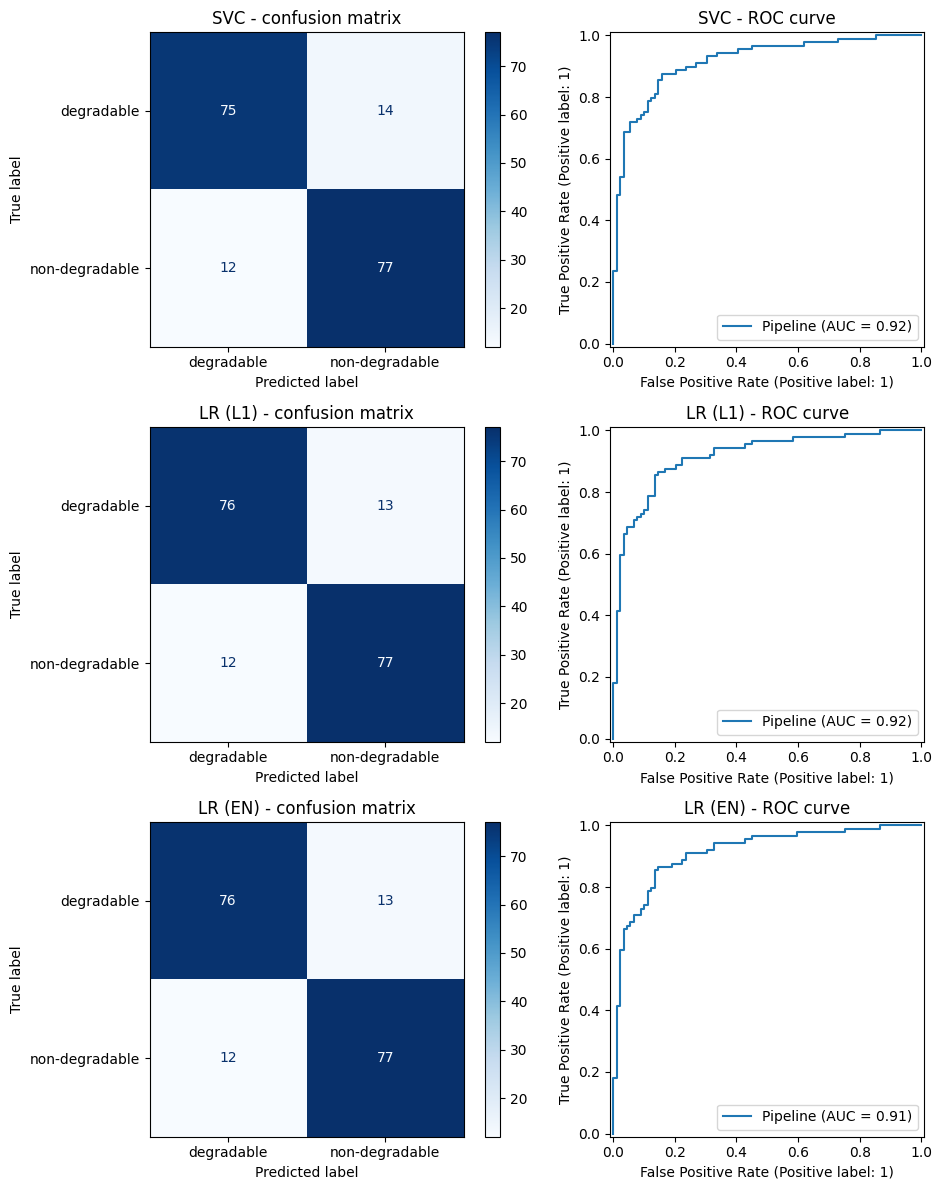

In [27]:
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay

def plot_evaluation_graphs(models: list[tuple[str, Pipeline]]):
    fig, ax = plt.subplots(len(models), 2, figsize=(10, 4 * len(models)))

    for i, model in enumerate(models):
        # Confusion Matrix
        ax[i][0].set_title(f"{model[0]} - confusion matrix")
        ConfusionMatrixDisplay.from_estimator(model[1], X_test, y_test, display_labels=["degradable", "non-degradable"], ax=ax[i][0], cmap="Blues")

        # ROC Curve
        ax[i][1].set_title(f"{model[0]} - ROC curve")
        RocCurveDisplay.from_estimator(model[1], X_test, y_test, ax=ax[i][1])

    fig.tight_layout()
    plt.show()

models = [
    ("SVC", model_svc),
    ("LR (L1)", model_Lasso),
    ("LR (EN)", model_EN),
]
plot_evaluation_graphs(models)

### Task 2.2 Plot the models coefficients variability across folds for the linear models (please rank the coefficients to facilitate interpretability)

In [71]:
from sklearn.model_selection import RepeatedKFold, cross_validate
import pandas as pd

def get_coefficients(model: Pipeline):
    # Get feature names after preprocessing (these are all 41 features)
    preprocessed_feature_names = model.named_steps['preprocessor'].get_feature_names_out()

    # Determine the actual feature names corresponding to the coefficients of the final model in the pipeline
    # Initialize with all preprocessed names; will be updated if feature selection is present
    final_feature_names_for_coefs = preprocessed_feature_names

    if 'feature_selection' in model.named_steps:
        feature_selection_step = model.named_steps['feature_selection']
        if hasattr(feature_selection_step, 'get_support'):
            # If there's a feature selection step and it's fitted, get the mask of selected features
            selected_mask = feature_selection_step.get_support()
            final_feature_names_for_coefs = preprocessed_feature_names[selected_mask]
        # else: if the feature selection step doesn't have get_support, we'd need a different strategy

    # Define repeated k-fold cross-validation
    cv = RepeatedKFold(n_splits=5, n_repeats=5, random_state=42)

    # Perform cross-validation and store estimators
    # cross_validate will clone the estimator (the 'model' pipeline) for each fold, then fit it.
    cv_model = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        return_estimator=True,
        n_jobs=-1,
        error_score="raise"
    )

    # Extract coefficients from trained models.
    # The last step of the pipeline ('linearsvc') contains the actual linear model.
    # The number of coefficients from est[-1].coef_.ravel() should match len(final_feature_names_for_coefs)
    return pd.DataFrame(
        [est[-1].coef_.ravel() for est in cv_model["estimator"]],
        columns=final_feature_names_for_coefs
    )

coefficients = [
    ("SVC", get_coefficients(model_svc)),
    ("LR (L1)", get_coefficients(model_Lasso)),
    ("LR (EN)", get_coefficients(model_EN)),
]

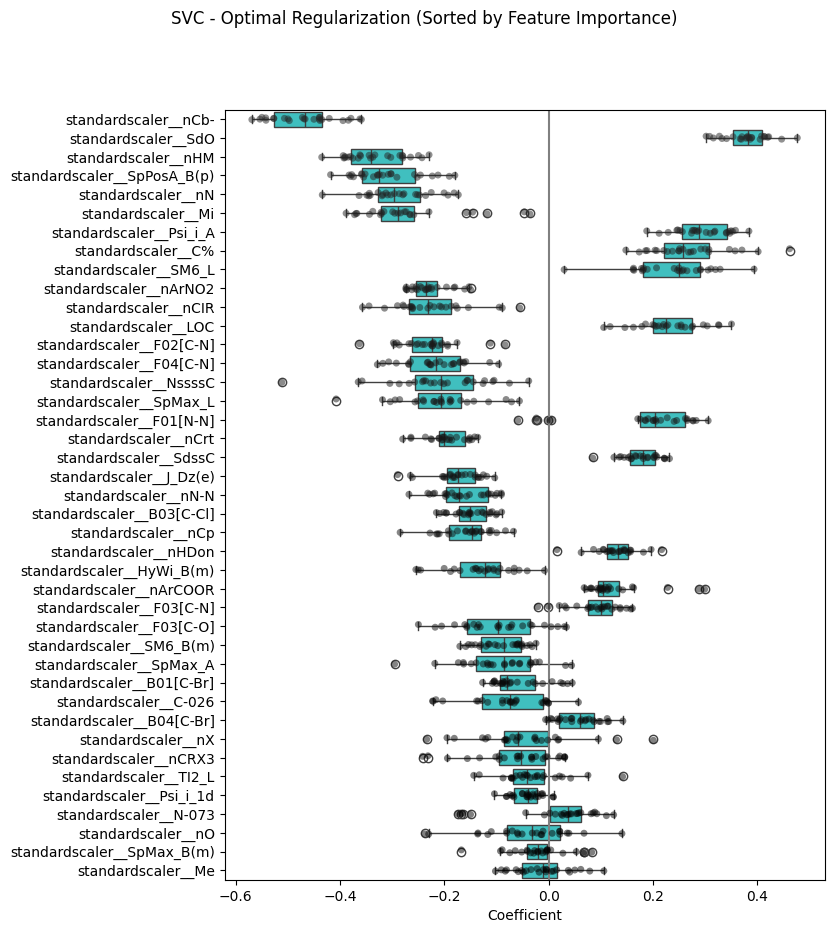

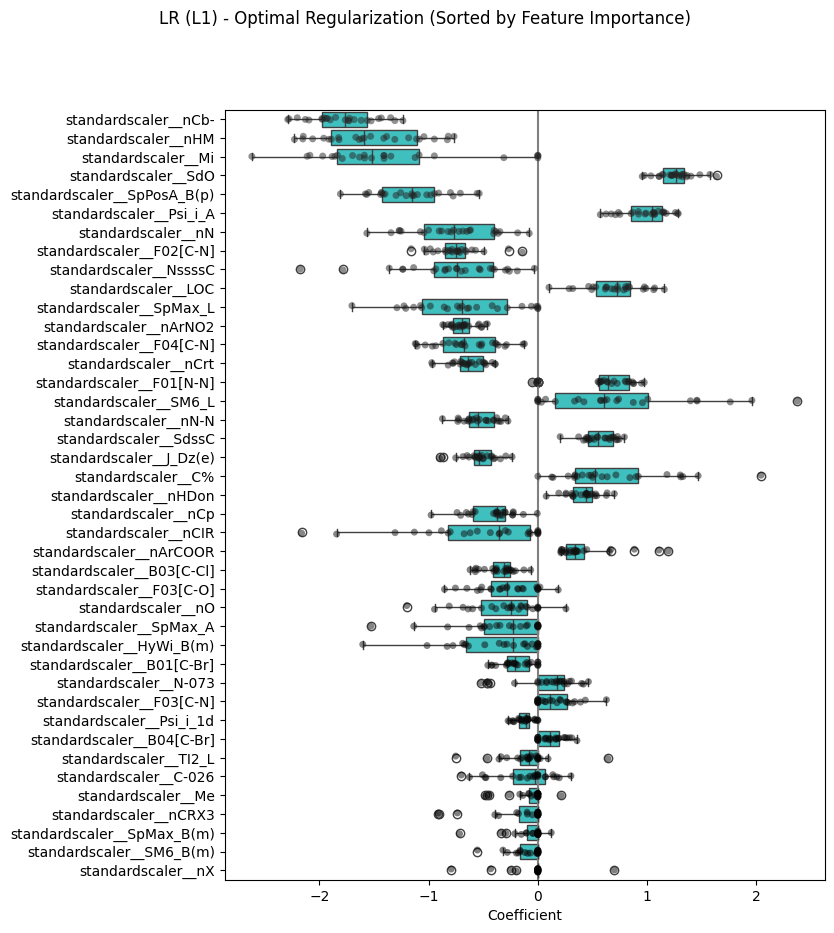

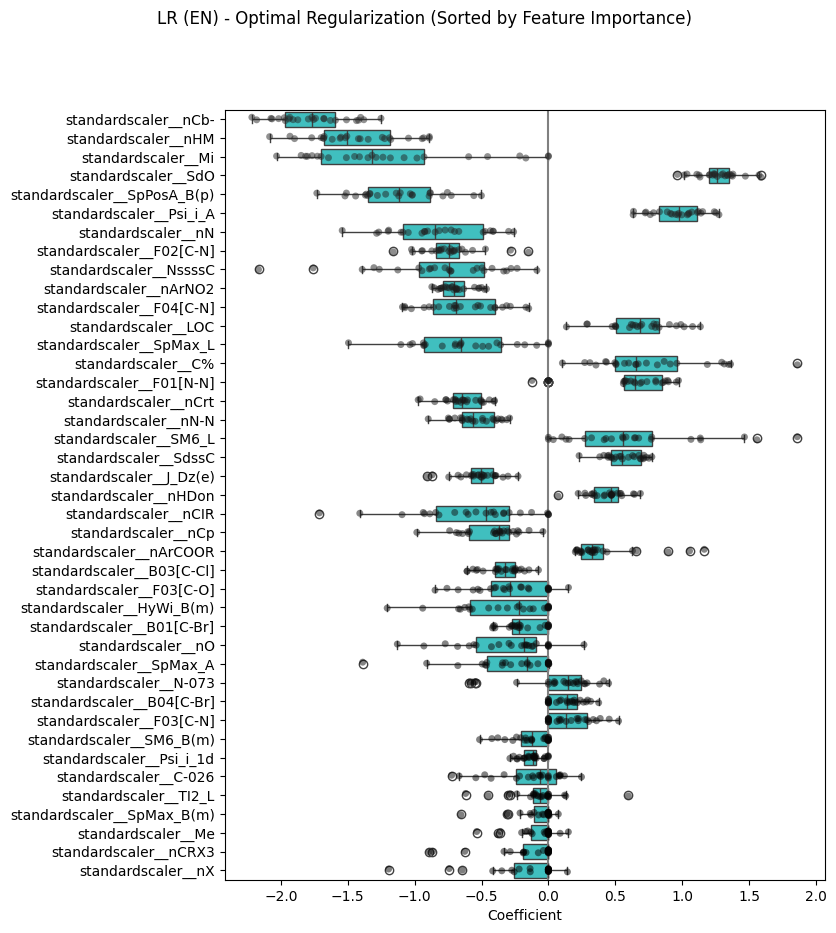

In [30]:
# Plot coefficient variability with ranked coefficients
def plot_coefficients(name: str, coefs: pd.DataFrame):
    # Calculate median absolute value for each feature and sort
    median_abs = coefs.median().abs().sort_values(ascending=False)
    sorted_features = median_abs.index.tolist()

    # Reorder coefficients by median absolute value
    coefs_sorted = coefs[sorted_features]

    plt.figure(figsize=(10, 10))
    sns.stripplot(data=coefs_sorted, orient="h", palette="dark:k", alpha=0.5)
    sns.boxplot(data=coefs_sorted, orient="h", color="cyan", saturation=0.5)
    plt.axvline(x=0, color=".5")
    plt.xlabel("Coefficient")
    plt.suptitle(f"{name} - Optimal Regularization (Sorted by Feature Importance)")
    plt.subplots_adjust(left=0.3)
    plt.show()

for i, coefficient in enumerate(coefficients):
    plot_coefficients(coefficient[0], coefficient[1])

Discussion: Are the coefficents across the different models similar?

**Analysis of Coefficient Similarity Across Models**

When comparing the coefficient plots for SVC, L1 (LASSO) Logistic Regression, and ElasticNet Logistic Regression, it's evident that while there might be some overlap in identifying the most influential features, the overall coefficient profiles and feature selection strategies vary significantly due to their distinct regularization approaches.

1. **SVC (Linear Support Vector Classifier)**:

Broad Feature Contribution: The SVC plot typically reveals that a relatively large number of features receive non-zero coefficients. This implies that many features contribute to the decision boundary, with no aggressive inherent mechanism to force coefficients to zero for feature selection. The magnitude of these coefficients reflects their influence on the separation hyperplane.
Moderate Sparsity: While some coefficients might be very small, SVC generally doesn't produce truly sparse solutions where many features are completely ignored.

Stability: The stability (spread of box and whiskers) varies per feature. Highly discriminative features might show consistent coefficients, while others might have more dispersed values across the folds, indicating less stable importance.

2. **L1 (LASSO) Logistic Regression**:

Strong Sparsity (Feature Selection): The LASSO plot stands out with its pronounced sparsity. A significant portion of features will have their coefficients shrunk exactly to zero. This is the hallmark of L1 regularization, effectively performing automatic feature selection by eliminating features deemed less important.

Identified Key Features: Only a subset of features will possess non-zero coefficients, and these are the features that LASSO considers most critical for prediction. These features will likely have larger absolute median coefficients.

Variability: For the features with non-zero coefficients, their stability can be moderate. However, the dominant observation is the strong selection effect, where features are either consistently included (non-zero) or consistently excluded (zero) across folds.

3. **ElasticNet Logistic Regression**:

Balanced Sparsity: ElasticNet's plot shows a compromise between SVC and LASSO. Like LASSO, it also drives some coefficients to zero, indicating feature selection. However, its L2 component means it might be less aggressive than pure LASSO in forcing coefficients to zero, especially for groups of correlated features.

Handling of Correlated Features: ElasticNet tends to group correlated features. If you have several features that convey similar information, ElasticNet is more likely to assign similar non-zero coefficients to all of them, rather than picking just one and setting others to zero (as LASSO might do).

Enhanced Stability: The L2 penalty in ElasticNet can contribute to more stable coefficients compared to pure L1 regularization, particularly for highly correlated features, as it avoids extreme weight fluctuations.

**Are the Coefficients Similar?**

No, the coefficients across the three models are generally not similar, especially in their overall profile and the degree of sparsity.

Differences in Feature Selection: The most significant difference lies in how each model handles feature selection. LASSO aggressively prunes features, leading to a much sparser model with fewer active coefficients. ElasticNet also prunes but often maintains more features, especially correlated ones. SVC uses all features more broadly.

Magnitude and Ranking: While there might be an overlap in the top few most important features (those with the highest absolute median coefficients), their precise magnitudes and the overall ranking of features can differ. A feature highly valued by LASSO might have a slightly different coefficient value or rank in SVC or ElasticNet.

Stability Variations: The stability (spread of the boxplots) for individual feature coefficients also varies, reflecting how consistently each model relies on a given feature across different data splits.

In essence, each model's underlying mathematical formulation and regularization technique lead to a unique interpretation of feature importance, resulting in distinct coefficient distributions and, consequently, different insights into which features are most critical and how they influence the prediction.

### Task 2.3 Plot the permutation feature importance for the different models.

Permutation importance works by randomly shuffling (permuting) the values of a single feature in the test set and then re-evaluating the model's performance (in this case, using AUC score). If permuting a feature significantly decreases the model's performance, it means that feature was important for the model's prediction. If permuting a feature has little effect, that feature was not very important.

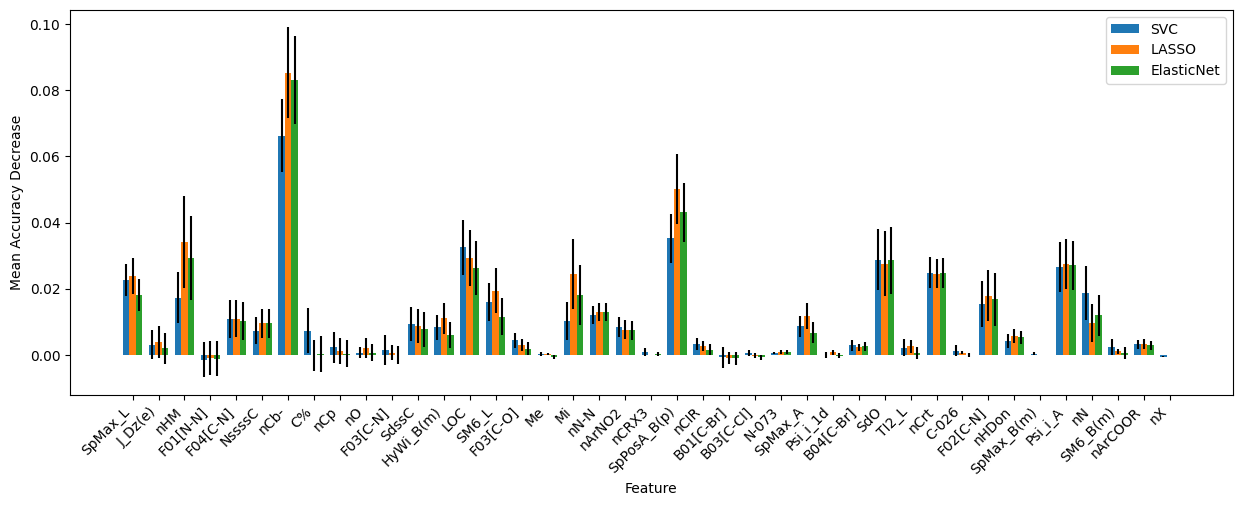

In [32]:
from sklearn.inspection import permutation_importance

# Extract feature names
feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

# Compute permutation importance for each model
result_svc = permutation_importance(
    model_svc,
    X_test,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

result_lasso = permutation_importance(
    model_Lasso,
    X_test,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

result_en = permutation_importance(
    model_EN,
    X_test,
    y_test,
    scoring='roc_auc',
    n_repeats=10,
    random_state=42,
    n_jobs=-1
)

# Plot feature importances
fig, ax = plt.subplots(figsize=(15, 5))
ax.bar(np.arange(0, 41) + 0.25, result_svc.importances_mean, yerr=result_svc.importances_std, width=0.25, label="SVC")
ax.bar(np.arange(0, 41) + 0.50, result_lasso.importances_mean, yerr=result_lasso.importances_std, width=0.25, label="LASSO")
ax.bar(np.arange(0, 41) + 0.75, result_en.importances_mean, yerr=result_en.importances_std, width=0.25, label="ElasticNet")
ax.set_xticks(np.arange(0, 41) + 0.5, feature_names, rotation=45, ha="right")
ax.legend()
ax.set_ylabel("Mean Accuracy Decrease")
ax.set_xlabel("Feature")

plt.show()

Discussion: Are the feature coefficients similar to the permutation importance for the different models?

Overall, for these linear models, there is a strong general similarity between the two. Features that consistently show high absolute coefficients in the box and whisker plots typically also have high permutation importance (tall bars in the permutation plots). This means that features deemed influential by the model's internal weighting are also those whose removal (via permutation) significantly degrades predictive performance.

### Task 2.4 Implement a similar pipeline for tree-based models and use the pipeline with Random Forest and Gradient Boosting trees to predict the degradability from the other features.
- Create a table to show the performance of the different models.
- Plot the confusion matrix and ROC curve for each model.

In [38]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Random Forest Model
cv_rf = optimise_hyperparameters(
    RandomForestClassifier(random_state=42),
    {'classify__n_estimators': [100, 200], 'classify__max_depth': [10, 20]}
)
rf_model = cv_rf.best_estimator_

# Gradient Boosting Model
cv_gb = optimise_hyperparameters(
    GradientBoostingClassifier(random_state=42),
    {'classify__n_estimators': [100, 200], 'classify__learning_rate': [0.05, 0.1]}
)
gb_model = cv_gb.best_estimator_

print("Done training models")

Fitting 5 folds for each of 4 candidates, totalling 20 fits
Fitting 5 folds for each of 4 candidates, totalling 20 fits
Done training models


In [42]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("Random Forest", rf_model, use_proba=True)
results_df.loc[1] = get_metrics("Gradient Boosting", gb_model)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,Random Forest,0.842697,0.842697,0.842697,0.842697,0.915415
1,Gradient Boosting,0.853933,0.853933,0.853933,0.853933,0.904431


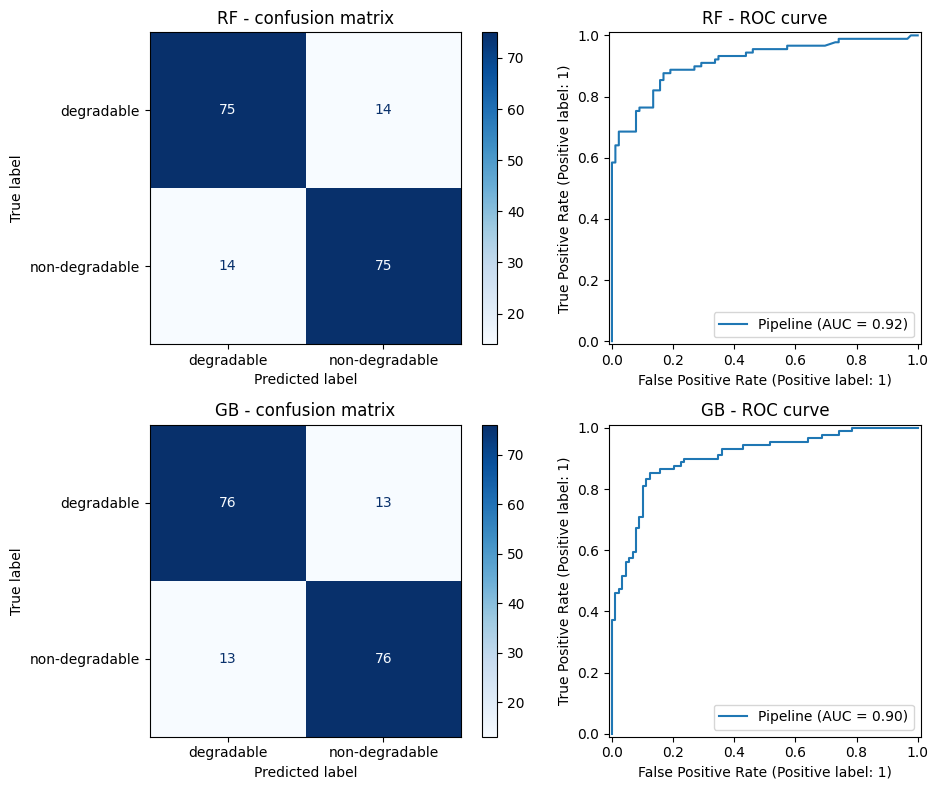

In [43]:
models = [
    ("RF", rf_model),
    ("GB", gb_model)
]

plot_evaluation_graphs(models)

### Task 2.5 Plot the feature importance for the different tree-based models

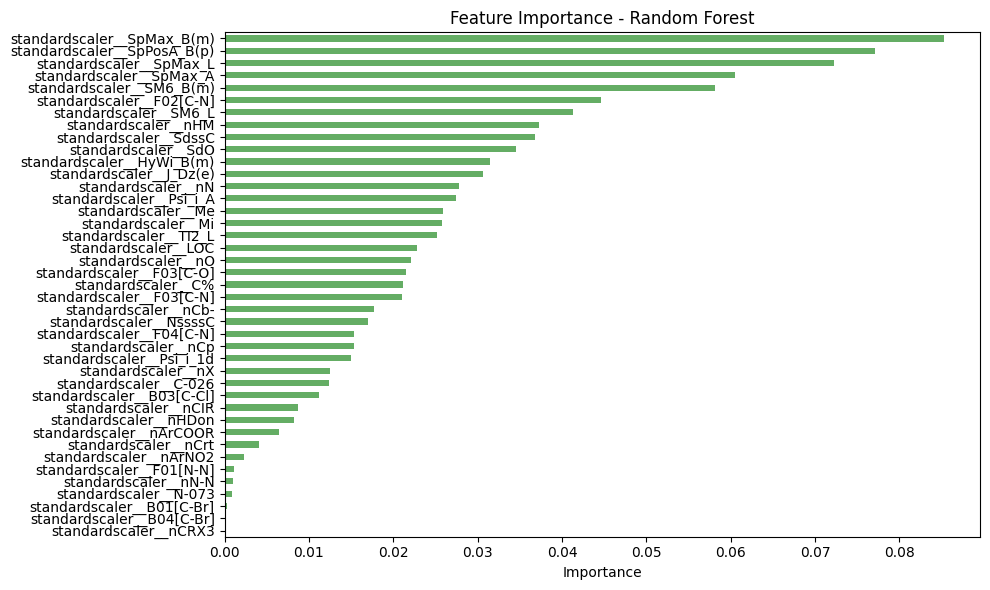

In [53]:
def plot_feature_importance(model, model_name):
    # Access the RandomForestClassifier inside the pipeline
    # This function is now generalized to work for any tree-based model passed.
    # The last step of the pipeline should be the model with feature_importances_ attribute.
    tree_based_model = model.steps[-1][1]

    # Get feature importances
    feature_importances = tree_based_model.feature_importances_

    # Extract feature names from the preprocessor
    feature_names = model.named_steps['preprocessor'].get_feature_names_out()

    # Create a pandas Series for better visualization
    importances_series = pd.Series(feature_importances, index=feature_names)

    # Plot feature importances
    fig, ax = plt.subplots(figsize=(10, 6))
    importances_series.sort_values().plot.barh(ax=ax, color="forestgreen", alpha=0.7)
    ax.set_title(f"Feature Importance - {model_name}") # Dynamic title
    ax.set_xlabel("Importance")
    fig.tight_layout()
    plt.show()

plot_feature_importance(rf_model, "Random Forest")

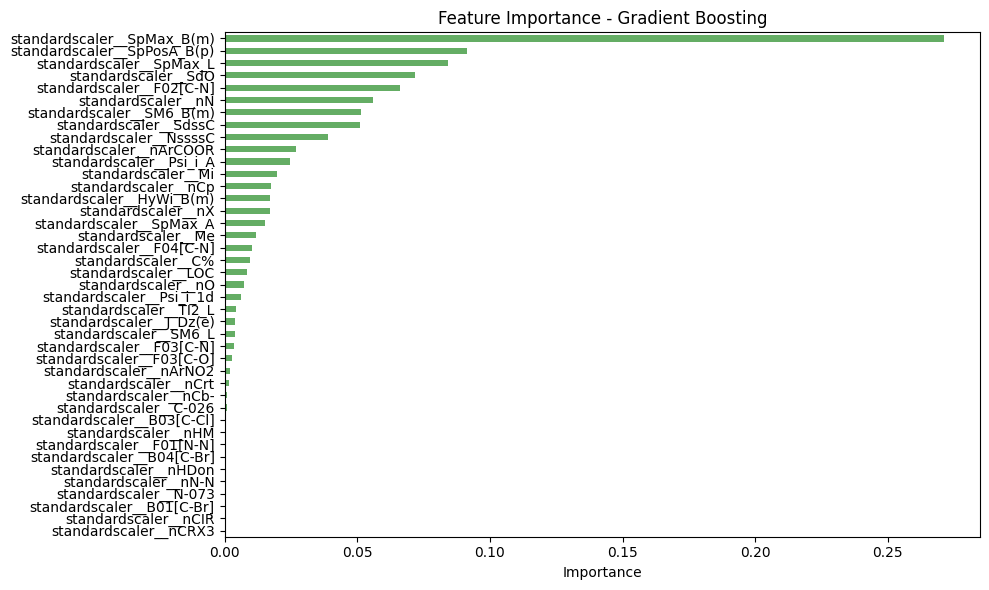

In [54]:
plot_feature_importance(gb_model, "Gradient Boosting")

### Task 2.6 Plot the permutation feature importance for the different tree-based models

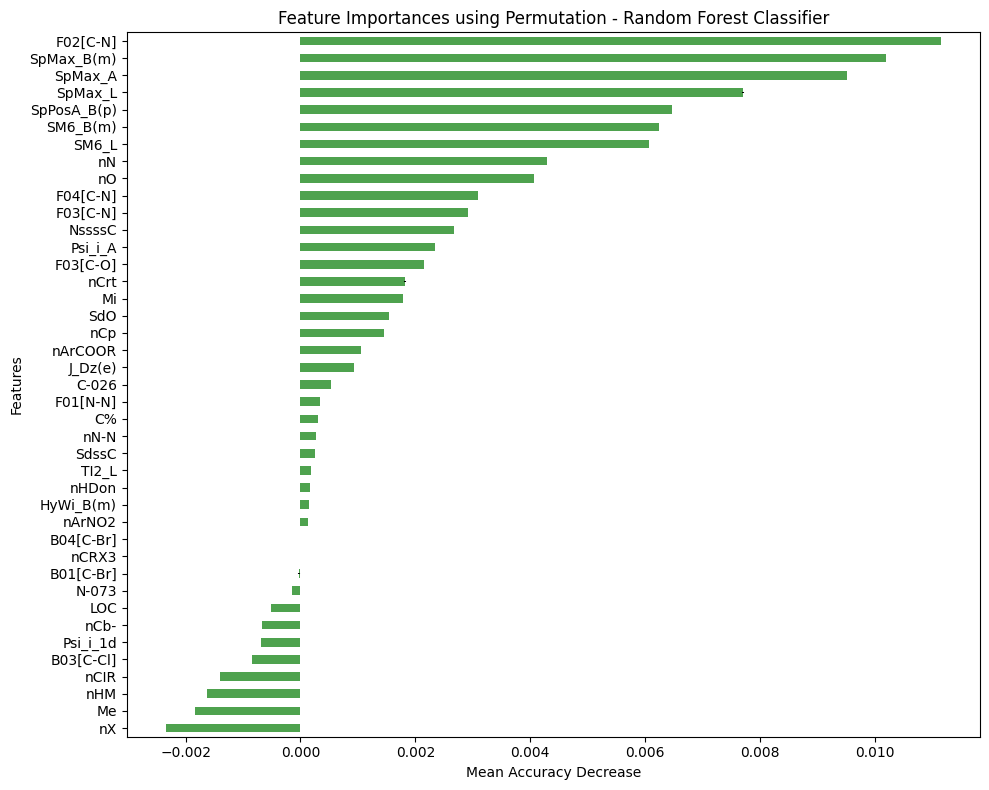

In [57]:
def plot_feature_importance_using_permutation(model, model_name):
    # Extract feature names
    feature_names = X_test.columns if hasattr(X_test, 'columns') else [f"Feature {i}" for i in range(X_test.shape[1])]

    # Compute permutation importance on the final estimator (RandomForestClassifier inside the pipeline)
    result = permutation_importance(
        model,
        X_test,
        y_test,
        scoring='roc_auc',
        n_repeats=10, # Added for robustness
        random_state=42, # Added for reproducibility
        n_jobs=-1 # Added for faster computation
    )

    # Convert to Pandas Series for easy plotting
    rf_importances = pd.Series(result.importances_mean, index=feature_names)

    # Plot feature importances with error bars
    fig, ax = plt.subplots(figsize=(10, 8))
    rf_importances.sort_values().plot.barh(yerr=result.importances_std, ax=ax, color="forestgreen", alpha=0.8)
    ax.set_title(f"Feature Importances using Permutation - {model_name}")
    ax.set_xlabel("Mean Accuracy Decrease")
    ax.set_ylabel("Features")
    fig.tight_layout()
    plt.show()

plot_feature_importance_using_permutation(rf_model, "Random Forest Classifier")

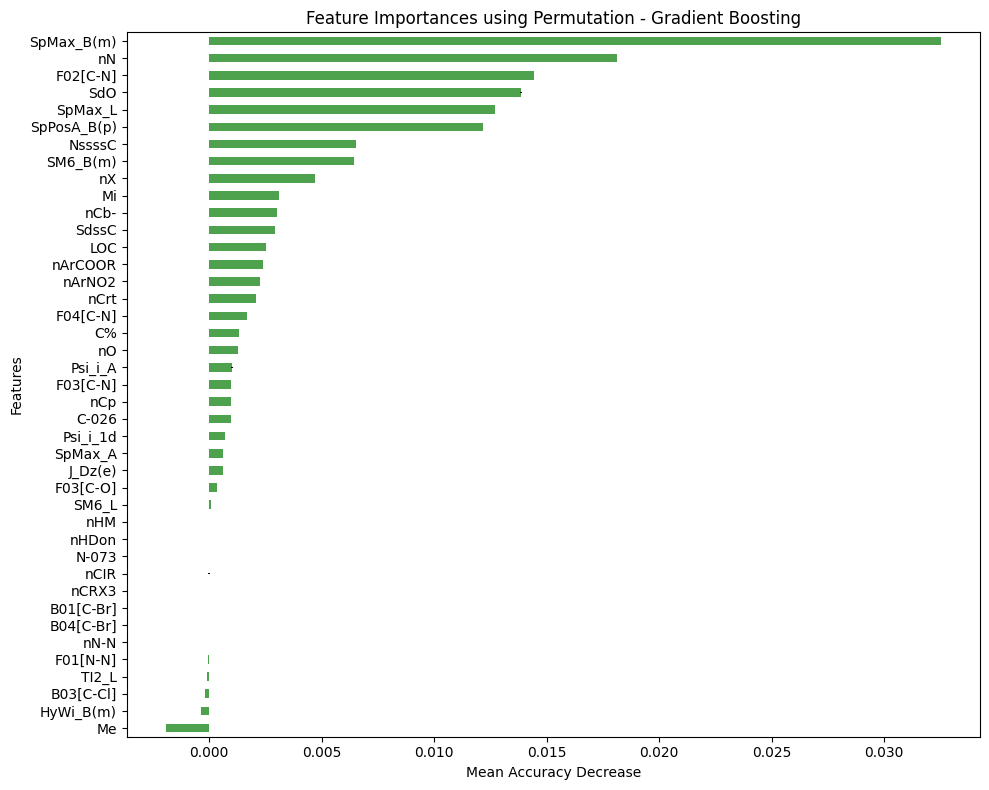

In [58]:
plot_feature_importance_using_permutation(gb_model, "Gradient Boosting")



Discussion: Are the feature importance and permutation feature importance similar for the different models?

Random Forest has a slightly smaller accuracy than the Gradient Boosting model. The RF model does not shrink coefficents to zero, while GB pushes some of the coefficients to zero. From the permutation importance plots, we can see that the features which RF did not shrink to zero(but GB did) are significant for the model's predictions. While, for the GB, the permutation importance plot shows that GB does not place the same significane on these coefficients, as it shrunk them to zero. So, the feature importance and permutation importance plots are notably different for the two models, despite similar performance metrics.   

Notes : Feature importance is quite criticised for tree based models, permutation importance is generally considered a better method to check how feature selection fares for tree based models.

### Task 2.7  For the best tree-based model use partial dependence plot to investigate dependence between the target response and each feature


Gradient Boosting Performance:
Accuracy: 0.8539
AUC: 0.9044
F1-score: 0.8539

Random Forest Performance:
Accuracy: 0.8427
AUC: 0.9154
F1-score: 0.8427

Best Model Selected: Random Forest


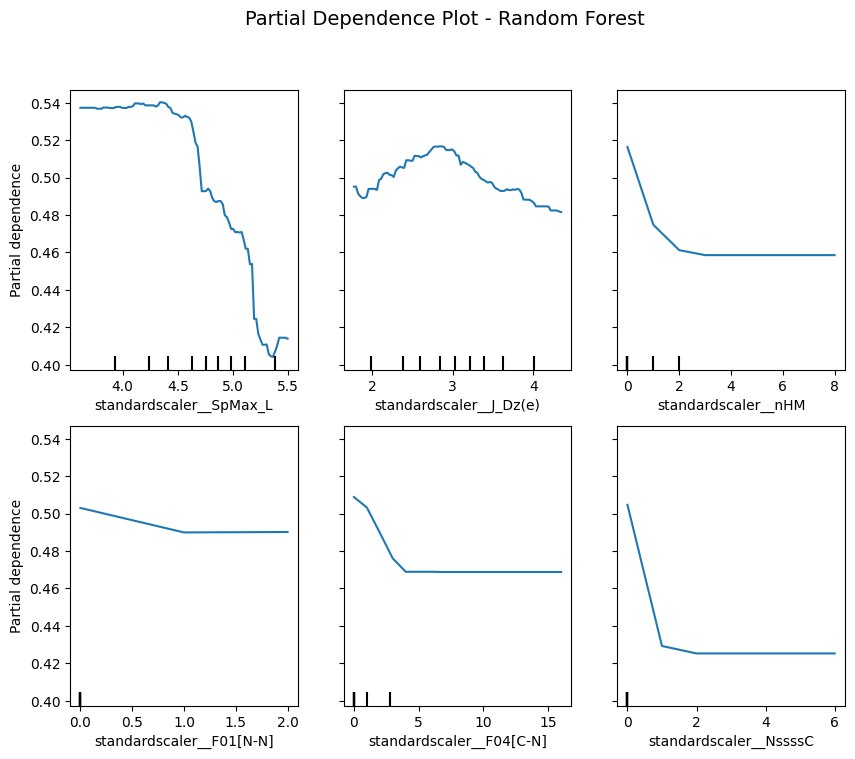

In [60]:
from sklearn.inspection import PartialDependenceDisplay

# Predictions & Probabilities for AUC Computation
y_pred_gb = gb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

y_proba_gb = gb_model.predict_proba(X_test)[:, 1]  # Probabilities for positive class
y_proba_rf = rf_model.predict_proba(X_test)[:, 1]

# Compute classification metrics
metrics = {
    "Gradient Boosting": {
        "Accuracy": balanced_accuracy_score(y_test, y_pred_gb),
        "AUC": roc_auc_score(y_test, y_proba_gb),
        "F1-score": f1_score(y_test, y_pred_gb),
    },
    "Random Forest": {
        "Accuracy": balanced_accuracy_score(y_test, y_pred_rf),
        "AUC": roc_auc_score(y_test, y_proba_rf),
        "F1-score": f1_score(y_test, y_pred_rf),
    }
}

# Print performance comparison
for model, scores in metrics.items():
    print(f"\n{model} Performance:")
    for metric, value in scores.items():
        print(f"{metric}: {value:.4f}")

# Select the best model (based on AUC)
if metrics["Gradient Boosting"]["AUC"] > metrics["Random Forest"]["AUC"]:
    best_model = gb_model
    best_model_name = "Gradient Boosting"
else:
    best_model = rf_model
    best_model_name = "Random Forest"
print(f"\nBest Model Selected: {best_model_name}")

# Partial Dependence Plot (for best model)
# Access the fitted preprocessor from within the best_model pipeline
fitted_preprocessor = best_model.named_steps['preprocessor']
features_to_plot = fitted_preprocessor.get_feature_names_out()[:6]  # Plot first 6 features for clarity

fig, ax = plt.subplots(figsize=(10, 8))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features_to_plot,
    ax=ax,
    feature_names=fitted_preprocessor.get_feature_names_out(),
    kind="average",
    n_jobs=-1
)
plt.suptitle(f"Partial Dependence Plot - {best_model_name}", fontsize=14)
plt.show()

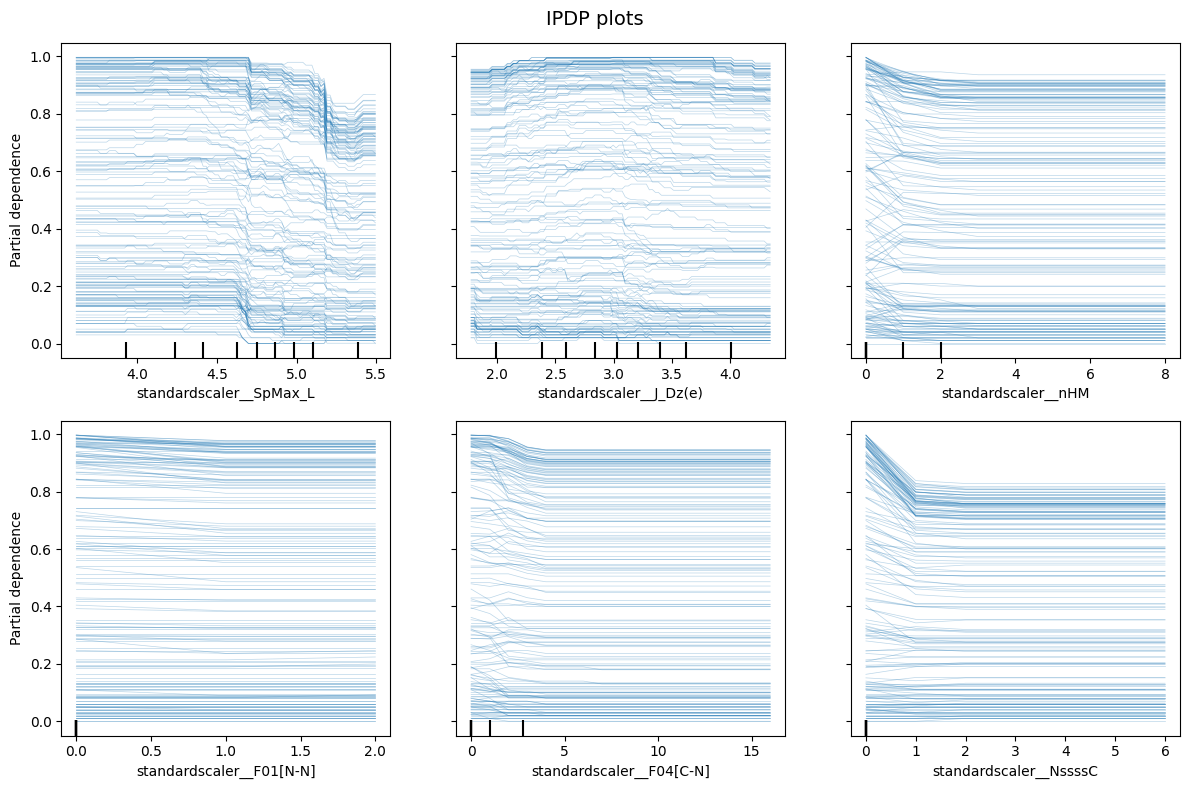

In [63]:
# Generate Individual Partial Dependence Plots (IPDP)
fig, ax = plt.subplots(figsize=(12, 8))
PartialDependenceDisplay.from_estimator(
    best_model,
    X_test,
    features_to_plot,
    ax=ax,
    feature_names=fitted_preprocessor.get_feature_names_out(),
    kind="individual",
    n_jobs=-1
)

plt.suptitle("IPDP plots", fontsize=14)
plt.tight_layout()
plt.show()

Here, we checked individual IPDLP plots to check for any outliers. But, the plots look quite stable.

## Task 3: Include feature selection within the cross-validation pipeline implemented in Task 1 and try two different feature selection strategies (select k best and recursive feature elimination) with the linear SVM model.
- Create a table to show the performance of the different models.
- Plot the confusion matrix and ROC curve for each model.

In [65]:
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.svm import LinearSVC

def make_feature_selection_pipline(feature_selection_step):
    param_grid = {'linearsvc__C': [0.1, 1,]}

    model_svc_select = Pipeline([
        ('preprocessor', preprocessor),
        ('feature_selection', feature_selection_step),
        ('linearsvc', LinearSVC(dual="auto", random_state=42))
    ])

    # Define cross-validation strategy
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    return GridSearchCV(
        estimator=model_svc_select,
        param_grid=param_grid,
        cv=cv,
        n_jobs=-1,
        error_score=0,
        verbose=1,
        refit=True,
    )

kbest_pipeline = make_feature_selection_pipline(
    SelectKBest(score_func=f_classif, k=10)
)

# Fit GridSearchCV
kbest_result = kbest_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [66]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

rfe_pipeline = make_feature_selection_pipline(
    RFE(estimator=LogisticRegression(max_iter=5000, solver="liblinear"), n_features_to_select=10),
)

rfe_result=rfe_pipeline.fit(X_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


In [67]:
results_df = pd.DataFrame(columns=["Model", "Accuracy", "Precision", "Recall", "F1-score", "AUC"])
results_df.loc[0] = get_metrics("KBest", kbest_result.best_estimator_)
results_df.loc[1] = get_metrics("RFE", rfe_result.best_estimator_)

results_df

,Model,Accuracy,Precision,Recall,F1-score,AUC
0,KBest,0.808989,0.766990,0.887640,0.822917,0.879182
1,RFE,0.825843,0.808511,0.853933,0.830601,0.889660


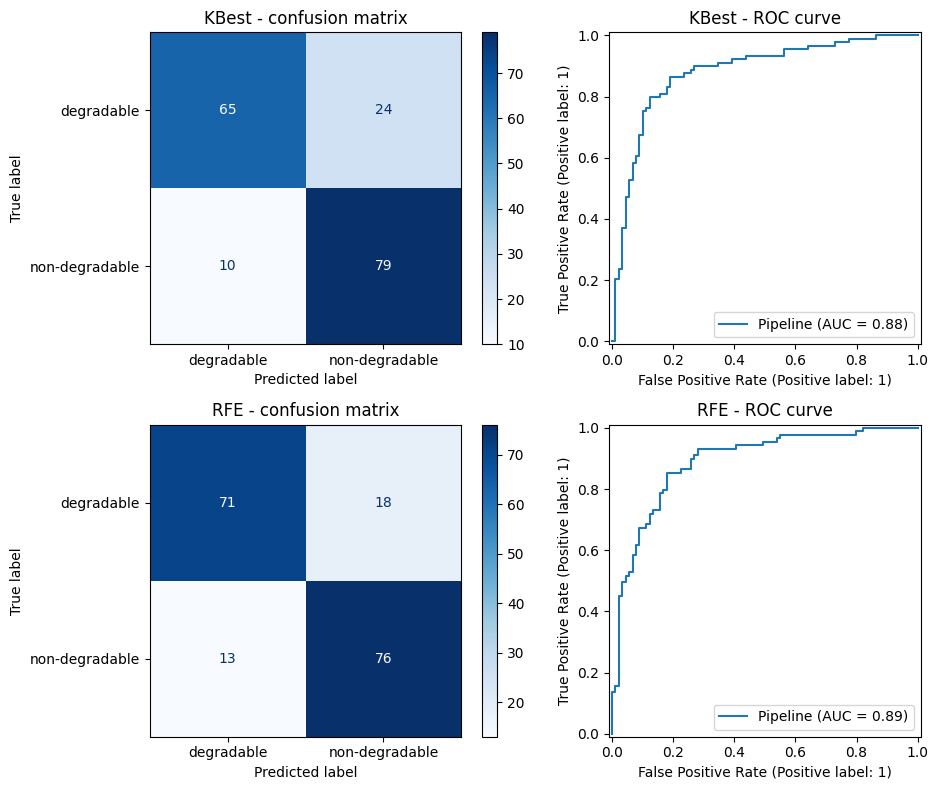

In [68]:
plot_evaluation_graphs([
    ("KBest", kbest_result.best_estimator_),
    ("RFE", rfe_result.best_estimator_)
])

Discussion: Did the model performance improved with feature selection?

In this particular case, it appears that model performance did not improve with the feature selection techniques (SelectKBest and RFE) when applied before the linear SVM. In fact, there was a slight decrease in overall performance metrics (especially AUC and Accuracy) compared to using all features with the regularized linear models (L1, ElasticNet, and SVC).

This could be due to several reasons:

The original number of features (41) might not be excessively high for the dataset size, so aggressive feature reduction (to 10 features in this case) might have removed some genuinely useful information.

The regularization inherent in the L1, ElasticNet, and SVC models might already be effectively handling feature selection and complexity, making explicit pre-processing feature selection less beneficial or even detrimental.

The specific choice of k=10 might have been too restrictive. Trying different values of k or other feature selection methods might yield different results.

Note: Generally, feature selection does not improve model performance. We mostly use it when there are computational and/or interpretability concerns.

### Task 3.2 Plot the coefficientes variability across folds for the linear model based on the selected features (please rank the coefficients to facilitate interpretability).

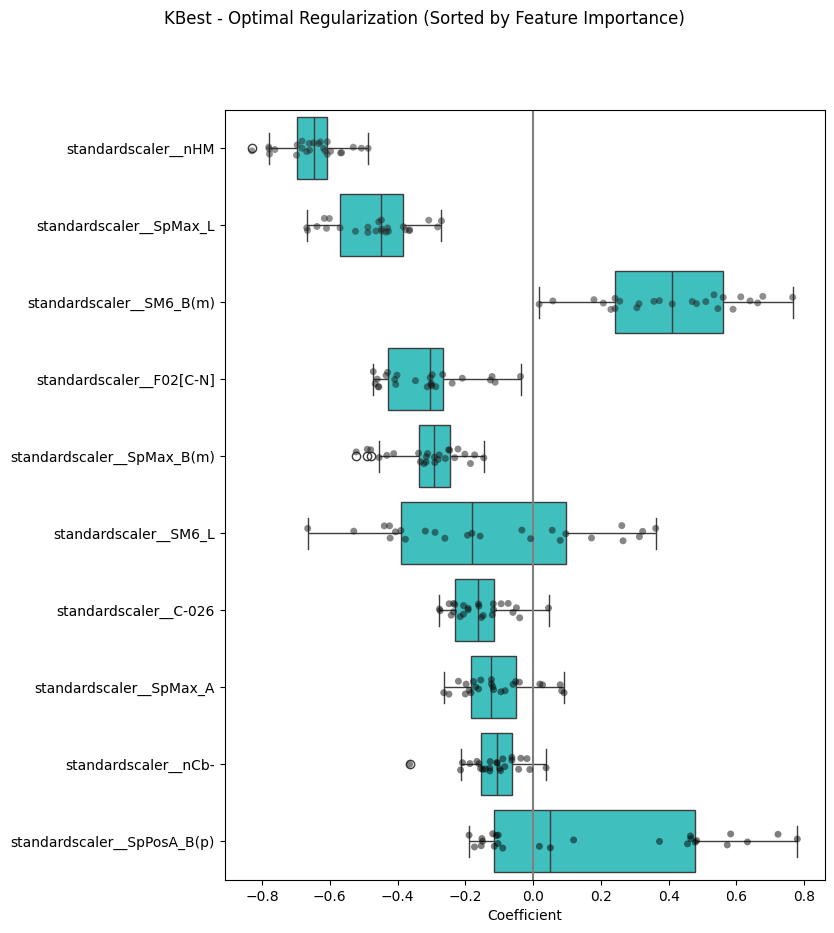

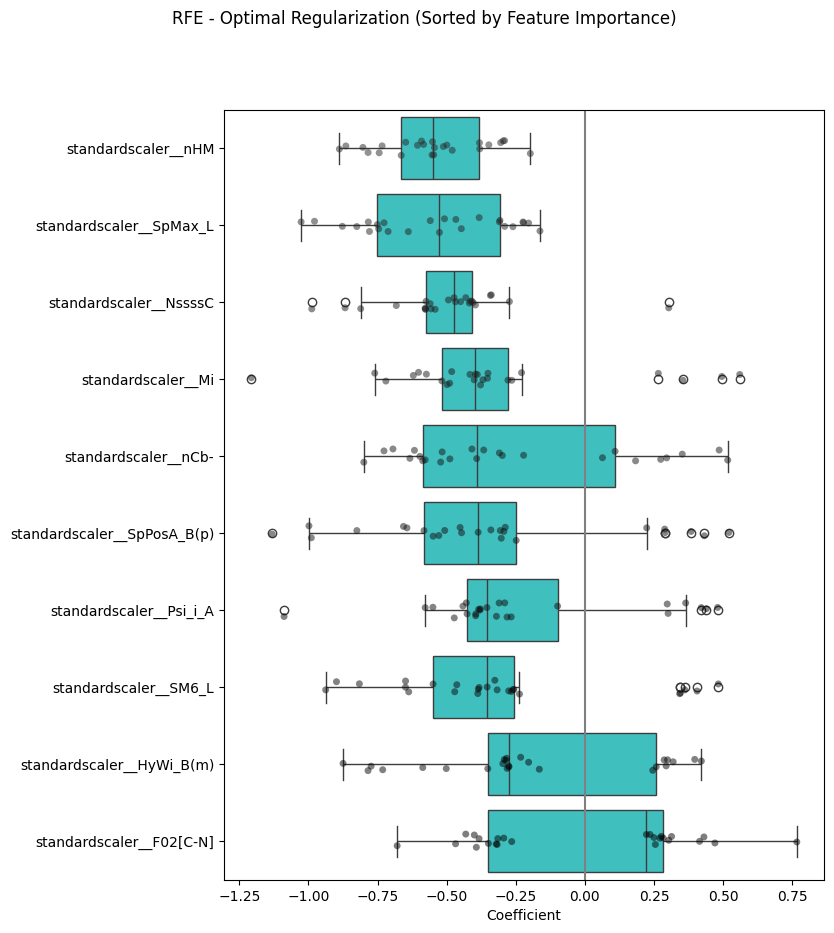

In [72]:
coefs_kbest = get_coefficients(kbest_result.best_estimator_)
plot_coefficients("KBest", coefs_kbest)

coefs_rfe = get_coefficients(rfe_result.best_estimator_)
plot_coefficients("RFE", coefs_rfe)

Discussion: Are similar features selected using the different strategies?

Yes, there is a substantial overlap (8 out of 10 features) in the features selected by SelectKBest and RFE. This suggests that for a majority of the top features, both univariate statistical ranking and multivariate model-based elimination agree on their importance for predicting biodegradability.

The differences in the remaining two features each method selects are also interesting. They highlight that while there's consensus on core features, the methods' underlying mechanisms lead to slightly different choices for less prominent features:

SelectKBest (using f_classif) evaluates each feature independently against the target. It picks features that have a strong individual statistical relationship with the target.
RFE (using LogisticRegression) considers features in the context of the model. It iteratively removes features that contribute least to the model's performance. This process can capture multivariate relationships or account for collinearity differently than a univariate test.
In conclusion, while there's strong agreement on the majority of important features, the slight divergence in the top 10 reinforces that different feature selection techniques can lead to slightly different sets of chosen features.